# jaxpulse Testing

In [1]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import *
from jaxpulse.optimizers import *
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

### Simple Qubit Flip Pulse Control

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/3008163740.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


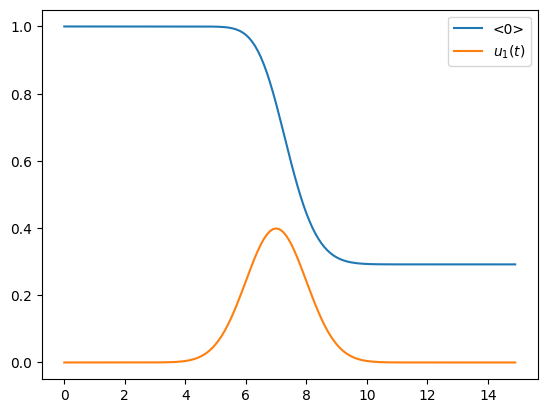

In [2]:
tls = ClosedQuantumSystem(
    H_0=dq.eye(2),
    H_M=[dq.sigmax()]
)
proj1 = dq.fock_dm(2,1)
proj0 = dq.fock_dm(2,0)
ctrl = OptimalController(
    system=tls,
    controls=ControlVector([GaussianHeightControl( # see also GaussianControl, GaussianShapedControl
        amp=jnp.array([1.0]),
        mean=jnp.array([7.0]),
        sigma=jnp.array([1.0]),
    )]),
    y0=dq.fock(2,0),
    duration=15.0,
    y_final=lambda psi_T: 1 - dq.expect(proj1, psi_T),
)
figpre,axpre = plt.subplots()
ctrl.plot(ax=axpre, exp_ops=[proj0],exp_names=["<0>"])
axpre.legend()
figpre.show()

In [3]:
ctrl2 = ctrl.optimize(N_steps=25,verbosity=2.0)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.1473675], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.2919265031814575
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.2571912], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.16883212327957153
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.3544966], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 2 Loss: 0.09516704082489014
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.4427173], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 3 Loss: 0.04606139659881592
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.5213764], dtype=float32),
      mean=Array([7.], dtype=float3

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/4202681757.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


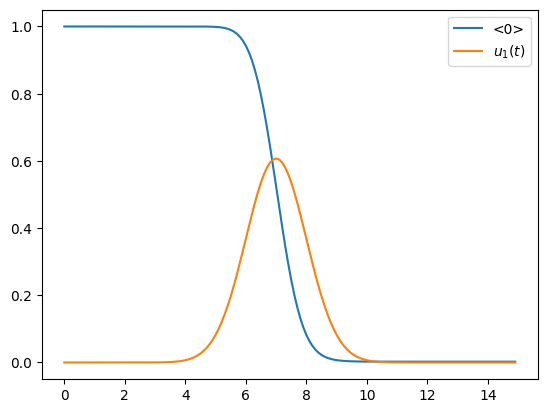

In [4]:

figpost, axpost = plt.subplots()
ctrl2.plot(ax=axpost,exp_ops=[proj0],exp_names=["<0>"])
axpost.legend()
figpost.show()

### Ancilla Reset Pulse Control

In [5]:
proj0 = dq.fock_dm(2,0)
proj1 = dq.fock_dm(2,1)
Delta = 1.
duration = 10.0
rho0 = dq.fock_dm(2,1)
gamma = 5
H_0 = dq.eye(2)
amp0 = jnp.sqrt(gamma)*dq.destroy(2)
loss_gaussian = ControlVector([
    GaussianHeightControl(
        amp=jnp.array([.5]),
        mean=jnp.array([duration/2]),
        sigma=jnp.array([.1])
    )
])
tls = OpenQuantumSystem(
    H_0=H_0,
    H_M=[],
    U_K=[],
    C_K=[amp0]
)

resetter = OptimalController(
    system=tls,
    controls=loss_gaussian,
    y0=rho0,
    duration=duration,
    y_final= lambda y: 1 - dq.expect(proj0, y)
)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_56998/2860268442.py:9: SyntaxWarning: invalid escape sequence '\h'
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/2860268442.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


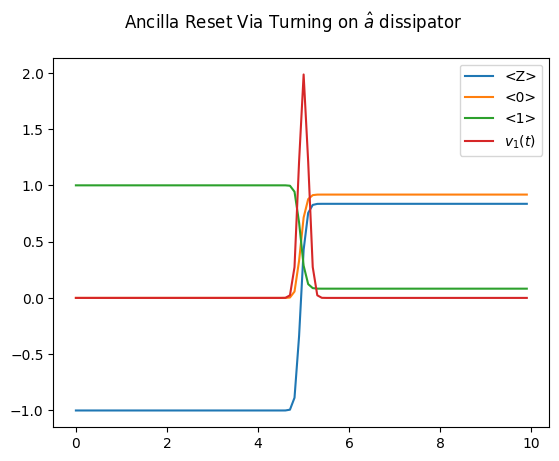

In [7]:
figpre, axpre = plt.subplots()
resetter.plot(
    ax=axpre,
    exp_ops=[dq.sigmaz(),proj0,proj1],
    exp_names=["<Z>","<0>","<1>"]
)
states = resetter.run()
axpre.legend()
figpre.suptitle("Ancilla Reset Via Turning on $\hat{a}$ dissipator")
figpre.show()


### Optimal Control on Simple Systems: Driven JC Model

#### System Setup

In [8]:
N_res = 4
N_qub = 2
omega_res = 3.0
omega_qub = 2.2
g = .1

a = dq.tensor(dq.destroy(N_res), dq.eye(N_qub))
b = dq.tensor(dq.eye(N_res), dq.destroy(N_qub))
Z = dq.tensor(dq.eye(N_res), dq.number(N_qub))
H_0 = omega_res * dq.dag(a)@a + omega_qub * dq.dag(b)@b # static Hamiltonian
H_1 = dq.dag(a) @ b + a @ dq.dag(b) # coupling
H_2 = 1./jnp.sqrt(2)*(a + dq.dag(a)) # X
H_3 = 1j/jnp.sqrt(2)*(dq.dag(a) - a) # P
H_M = [H_1, H_2]
psi_0 = dq.tensor(dq.fock(N_res,0),dq.fock(N_qub,0))


#### Control Setups

In [9]:
coupling_control = GaussianControl(
    amp=jnp.array([1.0, 1.0]),
    mean=jnp.array([5.0, 10.0]),
    sigma=jnp.array([1.0, 1.0])
)
drive_X = GaussianControl(
    amp=jnp.ones((4,)),
    mean=jnp.linspace(2,12,4),
    sigma=jnp.ones((4,))
)
drive_X = GaussianPulseTrain(
    amp =jnp.array([1.0]),
    mean=jnp.array([4.0]),
    sigma=jnp.array([.5]),
    period=jnp.array([6.0])
)

#### Optimizer Setup

In [10]:
jc_system = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)

jc_controls = ControlVector(
    [
        coupling_control,
        drive_X,
    ]
)

def final_penalty(psi_tF: Array) -> float:
    return 1 - dq.expect(Z, psi_tF)

duration= 15.0
controller = OptimalController(
    system=jc_system,
    controls=jc_controls,
    y0=psi_0,
    duration=duration,
    dt_start=.01,
    dt_save=.1,
    y_final=final_penalty,
)

#### Pre-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/105300645.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


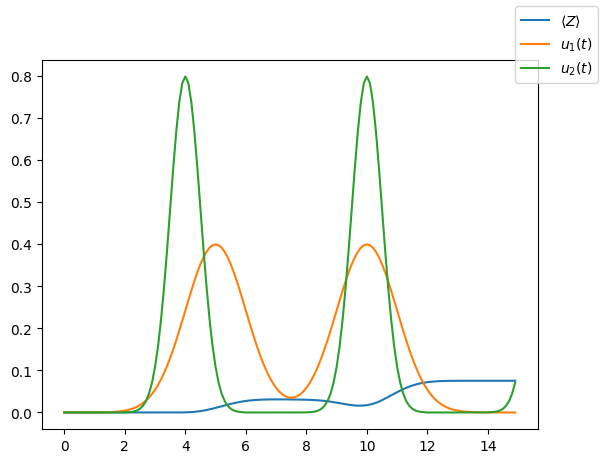

In [11]:
fig, ax = plt.subplots()
controller.plot(
    ax=ax,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig.legend()
fig.show()

#### Training

In [12]:
new_controller = controller.optimize(
    N_steps=40,
    learning_rate=.1,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473675, 1.1473675], dtype=float32),
      mean=Array([ 5.147366 , 10.1473675], dtype=float32),
      sigma=Array([0.8526326 , 0.85263276], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473675], dtype=float32),
      mean=Array([3.8526325], dtype=float32),
      sigma=Array([0.35263258], dtype=float32),
      period=Array([5.8526325], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.924675464630127
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2758495, 1.2758857], dtype=float32),
      mean=Array([ 5.032554, 10.275681], dtype=float32),
      sigma=Array([0.7260055, 0.7275133], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.2756591], dtype=float32),
      mean=Array([3.7245288], dtype=float32),
      sigma=Array([0.22435778], dtype=float32),
      period=Array([5.968145], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.6352506875991821
ControlVector(
  us=[
    GaussianControl(
     

#### Post-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/1590037031.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


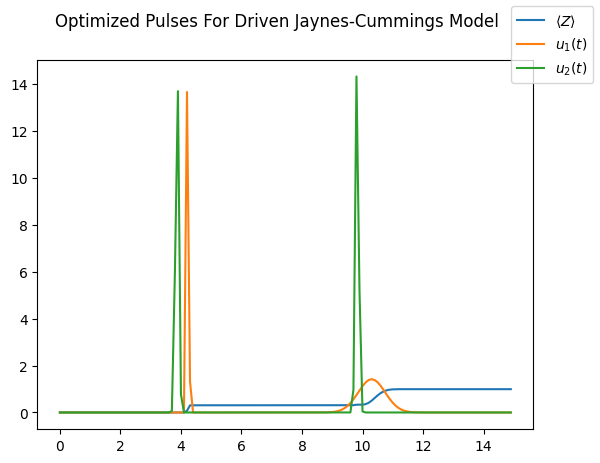

In [13]:
fig_opt, ax_opt = plt.subplots()
new_controller.plot(
    ax_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_opt.legend()
fig_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_opt.show()

### Open System Demos

In [14]:
U_0 = jnp.sqrt(.1)*a
open_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[U_0],
    C_K=[]
)
open_controls = jc_controls

open_controller = OptimalController(
    system=open_sys,
    controls=open_controls,
    y0=dq.todm(psi_0),
    duration=duration,
    y_final=final_penalty
)

#### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/2901399393.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


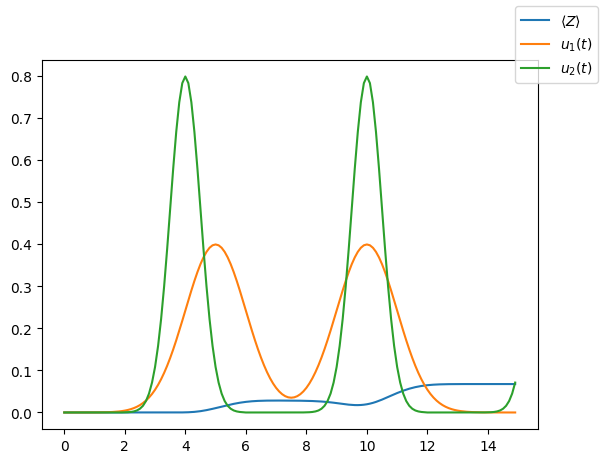

In [15]:
fig_pre, ax_pre = plt.subplots()
open_controller.plot(
    ax=ax_pre,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig_pre.legend()
fig_pre.show()

#### Train

In [16]:
opt_open_controller = open_controller.optimize(
    N_steps=100,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473675, 1.1473675], dtype=float32),
      mean=Array([ 4.852634 , 10.1473675], dtype=float32),
      sigma=Array([0.85263264, 0.85263276], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473674], dtype=float32),
      mean=Array([3.8526325], dtype=float32),
      sigma=Array([0.35263258], dtype=float32),
      period=Array([5.8526325], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.9325169324874878
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2757013, 1.2757152], dtype=float32),
      mean=Array([ 4.9722495, 10.275619 ], dtype=float32),
      sigma=Array([0.72495556, 0.72683024], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.2756709], dtype=float32),
      mean=Array([3.724114], dtype=float32),
      sigma=Array([0.22442289], dtype=float32),
      period=Array([5.959978], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.684356153011322
ControlVector(
  us=[
    GaussianControl(
  

#### Post-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_56998/353207557.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


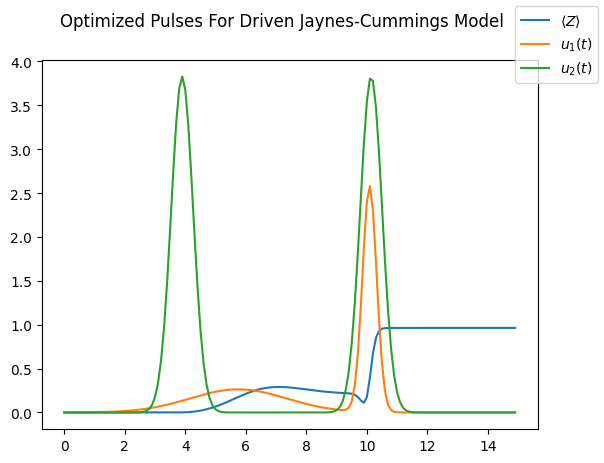

In [17]:
fig_open_opt, ax_open_opt = plt.subplots()
opt_open_controller.plot(
    ax_open_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_open_opt.legend()
fig_open_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_open_opt.show()
